In [0]:
import gc
import matplotlib
import numpy as np
import pandas as pd
import pickle
import sklearn
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import ParameterGrid
from numpy.random import shuffle
import os
import uuid
from google.colab import drive
import matplotlib.pyplot as plt
import keras

In [0]:
#print out memory usage
import sys

# These are the usual ipython objects, including this one you are creating
ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

# Get a sorted list of the objects and their sizes
sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)

##Get Data Together

In [0]:
all_data = pd.read_csv('all_data.csv') 
all_data.set_index(all_data.iloc[:,0],inplace=True)
all_data = all_data.iloc[:,1:]
# all_data.fillna(all_data.mean(),inplace=True)
data=all_data.values

In [13]:
del all_data
gc.collect()

72

In [0]:
n_feats = 22843

X = data[:,0:n_feats]
y = data[:,n_feats:] #predict only one drug
X = StandardScaler().fit_transform(X)

In [0]:
del data

## Model

In [0]:
def model_predict(x_train, n_lay, n_nodes, activation_func, n_output, dr_rate):
    layers = []
    for i in range(0, n_lay-1):
      new_layer = tf.layers.Dense(units=n_nodes, activation=activation_func,kernel_regularizer=keras.regularizers.l2(0.001))
      layers.append(new_layer)
    layers.append(tf.layers.Dense(units=n_output)) #should last activation func b dif?
    
    r = layers[0](x_train)
    d = tf.layers.dropout(r, rate = dr_rate)

    for i in range(1, n_lay):
        r = layers[i](d)
        d = tf.layers.dropout(r, rate = dr_rate)
    predictions_train = d
    return layers, predictions_train

In [0]:
def test_train_split(X,y,n_test):
    order = np.random.permutation(X.shape[0])
    feats_test = X[order[0:n_test],:] #90x22843
    outs_test = y[order[0:n_test],:] #90x122
    
    feats_train = X[order[n_test:],:] #361z22843
    outs_train = y[order[n_test:],:] #361x122

    return feats_train, outs_train, feats_test, outs_test

In [0]:
def nn(X, y, n_layers, n_nodes, activation_func, dr_rate, l_rate, n_output):
    
    validation = np.zeros(2)
    losses_train = []
    losses_test = []

    tf.reset_default_graph()
    n = X.shape[0]
    n_test = np.round(0.2 * n).astype('int64')
    n_epochs = 100
    
    for p in range(len(validation)):
        
        feats_train, outs_train, feats_test, outs_test = test_train_split(X,y,n_test)

        #prepare training Dataset
        training = tf.data.Dataset.from_tensor_slices((feats_train, outs_train))
        training = training.repeat(n_epochs).batch(n-n_test)
        iterator_train = training.make_one_shot_iterator()
        
        #prepare testing Dataset
        testing = tf.data.Dataset.from_tensor_slices((feats_test, outs_test))
        testing = testing.repeat(n_epochs).batch(n_test)
        iterator_test = testing.make_one_shot_iterator()
        
        #pull samples
        x_train, y_train = iterator_train.get_next()

        #predict
        keep_prob = tf.placeholder(tf.float32, shape=None, name='keep_prob')
        layers, y_train_pred = model_predict(x_train, n_layers, n_nodes, activation_func, n_output, keep_prob)
        del x_train
        
        # optimizer
        tf_learning_rate = tf.placeholder(tf.float32, shape=None, name='learning_rate')
        loss_train = tf.losses.mean_squared_error(labels=y_train, predictions=y_train_pred) # pass the second value from iter.get_net() as label
        l2_loss = tf.losses.get_regularization_loss()
        loss_train += tf.cast(l2_loss,tf.float32)
        train_op = tf.train.AdamOptimizer(tf_learning_rate).minimize(loss_train)
        
        #testing
        x_test, y_test = iterator_test.get_next()
        
        r = layers[0](x_test)
        for i in range(1,n_layers):
            r = layers[i](r)
        y_test_pred = r
        
        loss_test = tf.losses.mean_squared_error(labels=y_test, predictions=y_test_pred)
        del layers, x_test
        
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            for i in range(n_epochs):
              _, _loss_train, _loss_test, _y_train_pred, _y_train, _y_test_pred, _y_test= \
                    sess.run((train_op, loss_train, loss_test,y_train_pred,y_train,y_test_pred,y_test), feed_dict={tf_learning_rate: l_rate, keep_prob: dr_rate})
              print(_y_train_pred)
#               r2 = r2_score(y_true=_y_train, y_pred=_y_train_pred)
#               r2_test = r2_score(y_true=_y_test, y_pred=_y_test_pred)
              losses_train.append(_loss_train)
              losses_test.append(_loss_test)

            validation[p] = _loss_test
            print(validation[p])
#         print('r2: {0}, r2_test: {1}, validation: {2}'.format(0,0, np.mean(validation)))
        res = [0,0, losses_train, _y_train_pred, _y_train, losses_test, _y_test_pred, _y_test, validation]
    return res


# Training and Optimization

In [0]:
#example run with rand params
n_nodes = 100
n_layers = 7
l_rate = 0.01
n_output=122
activation_func = tf.nn.relu
dr_rate = 0.6 #prob that given node will be dropped out
# n_output=data.shape[1]-n_feats #122

n_feats = 22843

res = nn(X, y, n_layers, n_nodes, activation_func, dr_rate, l_rate, n_output)
r2, r2test, losses_train, _predictions_train, _sensitivity_train, losses_test, _predictions_test, _sensitivity_test, validation = res

### Hyperparameter tuning through randomized search

In [0]:
param_dist = {
    "n_layers" : [3,5,6,7,10],
    "n_nodes" : [50,100],
    "activation_func" : [tf.tanh,tf.nn.relu,tf.sigmoid],
    "dr_rate" : [0.4,0.5,0.6],
    "l_rate" : [1e-3,0.5,0.9],
    "n_output" : [122]
}
param_grid = list(ParameterGrid(param_dist))
shuffle(param_grid)

In [0]:
#params = {'dr_rate': 0.1, 'n_nodes': 200, 'l_rate': 0.5, 'activation_func': tf.sigmoid, 'n_layers': 3, 'n_output': 122}
params = {'dr_rate': 0.4, 'n_nodes': 100, 'l_rate': 0.001, 'activation_func': tf.nn.relu, 'n_layers': 3, 'n_output': 122} 

In [0]:
results4 = []
for i in range(0,int(len(param_grid)*0.3)):
    results4.append(nn(X,y,**param_grid[i]))
    print('Params: {0}\nAmount complete: {1:.3f}\n'.format(param_grid[i],i/(len(param_grid)*0.3)))

epoch: 0, r2: -49.861452278
epoch: 20, r2: -40.9140008979
epoch: 40, r2: -31.2855002369
epoch: 60, r2: -14.5604325743
epoch: 80, r2: -5.75819607881
r2: -2.59457467219, r2_test: -2.92628667096
epoch: 0, r2: -51.1039952161
epoch: 20, r2: -11.2192755801
epoch: 40, r2: -2.20756616154
epoch: 60, r2: -4.56996343048
epoch: 80, r2: -3.46000637309
r2: -0.582744797984, r2_test: -0.455854746793
Params: {'dr_rate': 0.5, 'n_nodes': 50, 'l_rate': 0.9, 'activation_func': <function tanh at 0x7ff2cb8705f0>, 'n_layers': 10, 'n_output': 122}
Amount complete: 0.000
epoch: 0, r2: -52.520094165
epoch: 20, r2: -3.10122839319
epoch: 40, r2: -0.0898726950624
epoch: 60, r2: -0.0123737113837
epoch: 80, r2: -0.0833234728894
r2: -0.0106086568311, r2_test: -0.0170687320485
epoch: 0, r2: -52.6109276869
epoch: 20, r2: -3.14676017333
epoch: 40, r2: -0.370568616179
epoch: 60, r2: -0.0101260396587
epoch: 80, r2: -0.00354658902786
r2: -0.000800050506756, r2_test: -0.0214431055078
Params: {'dr_rate': 0.6, 'n_nodes': 50, '

In [0]:
with open('model_results_optimized5.pkl', 'wb') as f:
    pickle.dump([param_grid,results4],f,protocol=2)

In [0]:
r2s_train5 = [r2 for r2,_, _, _, _, _, _, _, _ in results4]
r2s_test5 = [r2t for _,r2t, _, _, _, _, _, _, _ in results4]

In [0]:
len(param_grid)

In [0]:
best_train_params = param_grid[r2s_train5.index(max(r2s_train5))]
best_test_params = param_grid[r2s_test5.index(max(r2s_test5))]
print('Best Train R2: {0} \nBest Test R2: {1}'.format(max(r2s_train5),max(r2s_test5)))
print('Best Train Params: {0} \nBest Test Params: {1}'.format(best_train_params,best_test_params))

Best Train R2: 0.154347107813 
Best Test R2: -0.0103134143273
Best Train Params: {'dr_rate': 0.4, 'n_nodes': 100, 'l_rate': 0.001, 'activation_func': <function relu at 0x7ff2cb6c1758>, 'n_layers': 3, 'n_output': 122} 
Best Test Params: {'dr_rate': 0.6, 'n_nodes': 50, 'l_rate': 0.9, 'activation_func': <function sigmoid at 0x7ff2cb650320>, 'n_layers': 7, 'n_output': 122}


In [0]:
op_res1 = nn(X,y,**best_train_params)
op_res2 = nn(X,y,**best_test_params)

epoch: 0, r2: -51.8706911383
epoch: 20, r2: -14.6300883529
epoch: 40, r2: -1.77906160913
epoch: 60, r2: -0.340525276357
epoch: 80, r2: 0.0243728741657
r2: 0.140559354777, r2_test: -1.04513035052
epoch: 0, r2: -53.2292475697
epoch: 20, r2: -15.3765402969
epoch: 40, r2: -1.71773592667
epoch: 60, r2: -0.274735302265
epoch: 80, r2: 0.0620004948297
r2: 0.163157029706, r2_test: -1.02013880934
epoch: 0, r2: -52.4589651146
epoch: 20, r2: -2.57708697315
epoch: 40, r2: -0.0780679742507
epoch: 60, r2: -0.0701668082514
epoch: 80, r2: -0.0915660324914
r2: -0.00811110814268, r2_test: -0.0265689350421
epoch: 0, r2: -50.8508652051
epoch: 20, r2: -1.39875032419
epoch: 40, r2: -0.056715147317
epoch: 60, r2: -0.149270214776
epoch: 80, r2: -0.0011381808715
r2: -0.0329185624405, r2_test: -0.0431043337066


In [0]:
r2, r2test, losses_train, _y_train_pred, _y_train, losses_test, _y_test_pred, _y_test, validation = op_res1

In [0]:
best_test_params

{'activation_func': <function tensorflow.python.ops.math_ops.sigmoid>,
 'dr_rate': 0.3,
 'l_rate': 0.5,
 'n_layers': 6,
 'n_nodes': 100,
 'n_output': 1}

### Visualizing Results

In [0]:
with open('model_results.pkl', 'rb') as f:  # Python 3: open(..., 'rb')
    a = pickle.load(f)

In [0]:
_y_train

array([[156.65792428, 149.80661967, 187.45167356, ..., 159.00005935,
        244.41502444, 244.35669576],
       [156.65792428, 149.80661967, 187.45167356, ..., 159.00005935,
        244.41502444, 244.35669576],
       [154.35910879, 239.51903682, 187.45167356, ..., 172.67462319,
        172.65444755, 286.26399999],
       ...,
       [156.65792428, 149.80661967, 187.45167356, ..., 159.00005935,
        244.41502444, 244.35669576],
       [156.65792428, 149.80661967, 187.45167356, ..., 159.00005935,
        244.41502444, 244.35669576],
       [210.17814666, 152.37674996, 230.21701357, ..., 150.40487433,
        285.20538727, 246.70247432]])

In [0]:
np.mean(validation)

1974.258544921875

Text(0.5,1,'Pred vs Train - Multiple Drugs')

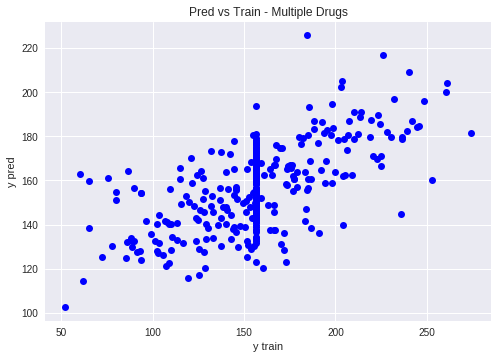

In [0]:
y_train = pd.DataFrame(_y_train)
y_pred = pd.DataFrame(_y_train_pred)
plt.plot(y_train.iloc[:,0],y_pred.iloc[:,0],'bo')
plt.xlabel('y train')
plt.ylabel('y pred')
plt.title('Pred vs Train - Multiple Drugs')
# Best Train R2: 0.154347107813 
# Best Test R2: -0.0103134143273
# Best Train Params: {'dr_rate': 0.4, 'n_nodes': 100, 'l_rate': 0.001, 'activation_func': <function relu at 0x7ff2cb6c1758>, 'n_layers': 3, 'n_output': 122} 
# Best Test Params: {'dr_rate': 0.6, 'n_nodes': 50, 'l_rate': 0.9, 'activation_func': <function sigmoid at 0x7ff2cb650320>, 'n_layers': 7, 'n_output': 122}

#but testing data is shit

Text(0.5,1,'Pred vs Test - Multiple Drugs')

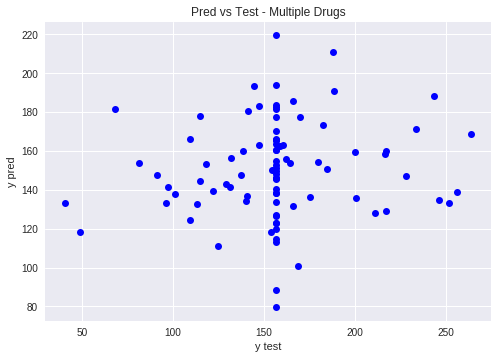

In [0]:
y_test = pd.DataFrame(_y_test)
y_pred = pd.DataFrame(_y_test_pred)
plt.plot(y_test.iloc[:,0],y_pred.iloc[:,0],'bo')
plt.xlabel('y test')
plt.ylabel('y pred')
plt.title('Pred vs Test - Multiple Drugs')

#Best Train Params: {'dr_rate': 0.3, 'n_nodes': 100, 'l_rate': 0.5, 'activation_func': <function sigmoid at 0x7fcd3011b6e0>, 'n_layers': 3, 'n_output': 1} 
#Best Train R2: 0.942072275879 

#but testing data is shit

In [1]:
plt.hist(X)

NameError: ignored

(array([ 1.,  1.,  5.,  4., 21., 16., 17., 17.,  6.,  2.]),
 array([ 71.3854787 ,  84.27880084,  97.17212298, 110.06544512,
        122.95876727, 135.85208941, 148.74541155, 161.63873369,
        174.53205583, 187.42537797, 200.31870011]),
 <a list of 10 Patch objects>)

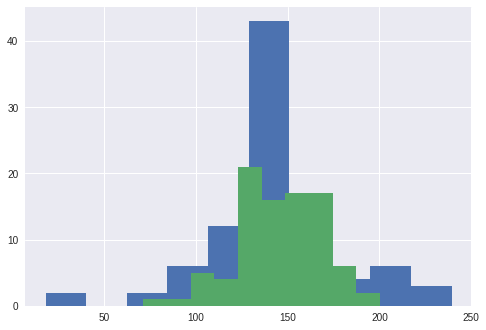

In [0]:
plt.hist(y_test.iloc[:,1])
plt.hist(y_pred.iloc[:,1])

Text(0.5,1,'Train and Test Values')

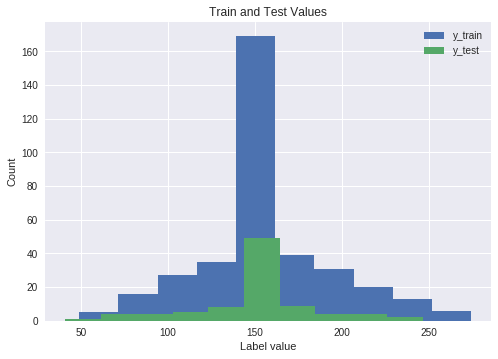

In [0]:
plt.hist(_y_train, label='y_train')
plt.hist(_y_test, label = 'y_test')
plt.xlabel('Label value')
plt.ylabel('Count')
plt.legend()
plt.title('Train and Test Values')

In [0]:
#plot test/trainig error
plt.plot(losses_train[0:100], label = 'train set')
plt.plot(losses_test[0:100], label = 'test set')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Loss Per Epoch')
plt.show()